In [5]:

%pip install gpxpy folium

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import folium
import gpxpy

In [7]:
# обработка точек

gpx_points = []

with open("Geo_data.gpx", encoding="utf8") as f:
  gpx = gpxpy.parse(f)
  for track in gpx.tracks:
    for segment in track.segments:
      for point in segment.points:
        gpx_points.append(point)

points = [(point.latitude, point.longitude) for point in gpx_points]

In [8]:
# время поездки

seconds = (gpx_points[-1].time - gpx_points[0].time).seconds

seconds / 60

76.15

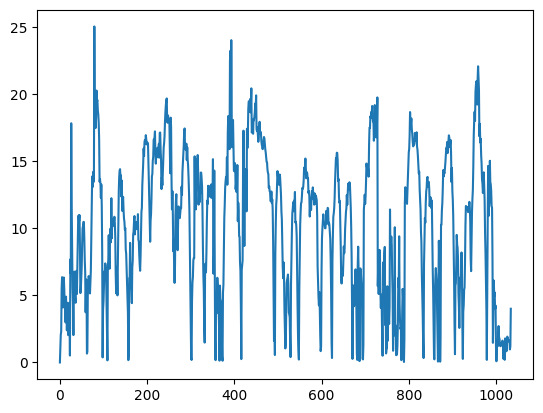

In [9]:
# график скорости

speed = [0] + [point.speed_between(gpx_points[i-1]) for i, point in enumerate(gpx_points) if i > 0]

plt.plot(speed)

In [10]:
# расстояние между точками
# rgb(174,198,207)
r = 174
g = 198
b = 227

gap_markers = []

for i, point in enumerate(gpx_points):
    if i == 0: continue

    dist = point.distance_2d(gpx_points[i-1])

    if dist < 100: continue

    midpoint = (
        points[i-1][0] + (points[i][0] - points[i-1][0])/2,
        points[i-1][1] + (points[i][1] - points[i-1][1])/2
    )

    gap_markers.append(
          folium.vector_layers.Circle(
            midpoint,
            radius=dist/2,
            color=f"#{r:02x}{g:02x}{b:02x}",
            fill=True,
            fill_opacity=0.7
        )
    )

gap_markers

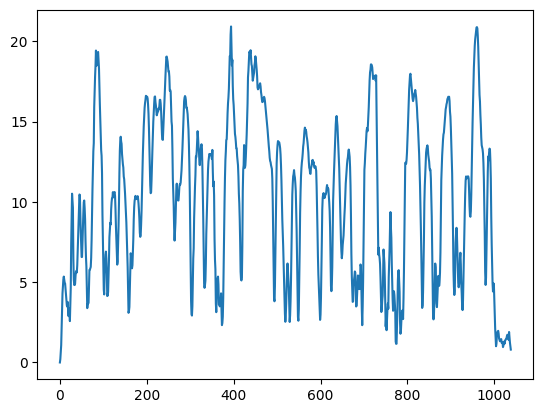

In [11]:
conv = np.convolve(speed, np.asarray([1, 1, 1, 1, 1]) / 5)

plt.plot(conv)

In [12]:
lat_min = float("inf")
lat_max = 0
lon_min = float("inf")
lon_max = 0

for point in points:
  if point[0] > lat_max:
    lat_max = point[0]
  if point[0] < lat_min:
    lat_min = point[0]
  if point[1] > lon_max:
    lon_max = point[1]
  if point[1] < lon_min:
    lon_min = point[1]

map_lat = lat_min + (lat_max - lat_min)/2
map_lon = lon_min + (lon_max - lon_min)/2

lat_max, lat_min, lon_max, lon_min, map_lat, map_lon

(55.67597842,
 55.63425767,
 37.66344799,
 37.47580248,
 55.655118044999995,
 37.569625235000004)

In [13]:
# маршрут

m = folium.Map(location=(map_lat, map_lon), zoom_start=13, zoom_control=False)

folium.PolyLine(points, ).add_to(m)

folium.Marker(
    location=points[0],
    icon=folium.Icon(color="green"),
).add_to(m)

folium.Marker(
    location=points[-1],
    icon=folium.Icon(color="red"),
).add_to(m)

folium.Marker(
    location=points[-26],
    icon=folium.Icon(color="blue"),
).add_to(m)

m

In [14]:
# визуализация скорости

m = folium.Map(location=(map_lat, map_lon), zoom_start=13, zoom_control=False)

min_color = (255, 0, 0)
max_color = (0, 255, 0)
gray_color = (128, 128, 128)

min_speed, max_speed = min(speed), max(speed)
colors = []

for s in speed:
    ratio = (s - min_speed) / (max_speed - min_speed) if max_speed > min_speed else 0
    r = int(min_color[0] + ratio * (max_color[0] - min_color[0]))
    g = int(min_color[1] + ratio * (max_color[1] - min_color[1]))
    b = int(min_color[2] + ratio * (max_color[2] - min_color[2]))
    colors.append(f"#{r:02x}{g:02x}{b:02x}")

for point, s, c in zip(points, speed, colors):
  folium.vector_layers.Circle(
    point,
    radius=15,
    color=c,
    fill=True,
    fill_opacity=0.9
).add_to(m)

folium.Marker(
    location=points[0],
    icon=folium.Icon(color="green"),
).add_to(m)

folium.Marker(
    location=points[-1],
    icon=folium.Icon(color="red"),
).add_to(m)

folium.Marker(
    location=points[-26],
    icon=folium.Icon(color="blue"),
).add_to(m)

for marker in gap_markers:
    marker.add_to(m)

m